## **Titanic Dataset solution**

**Question-Problem Statement**

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this solution we will predict whether a person survives or not based on various factors like social class, gender and age.

In [1]:
# Import necessary packages
import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.simplefilter("ignore")
import os
print(os.listdir("../input"))
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.metrics import explained_variance_score
from xgboost import XGBClassifier

['test.csv', 'train.csv', 'gender_submission.csv']


In [2]:
# Load train dataset
train=pd.read_csv('../input/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Load test dataset
test=pd.read_csv('../input/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## **Data Wrangling**
First we will deal with missing and incorrect data.
First lets drop the columns we will not be needing from both datasets.
After analysis we can see that Age has missing data in both train and test data.
In tain dataset Embarked has some missing values.


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Drop uneccessary columns
train.drop(columns=['PassengerId','Name','Cabin','Ticket','Fare'],inplace=True)
test.drop(columns=['Name','Ticket','Cabin','Fare'],inplace=True)

For filling the missing values of the age dataset lets get the mean of each class furthur divided by sex. Then we will fill these mean values in the coressponding class and sex.

In [6]:
# Get index with null values in train dataset
index_list=train[train['Age'].isnull()].index
index_list

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

In [7]:
# Fill those null values with appropiate mean values
for index in index_list:
    if train.loc[index,'Pclass']==1 and train.loc[index,'Sex']=='female':
        train.loc[index,'Age']=np.ceil(train.groupby(['Pclass','Sex'])['Age'].mean()[1][0])
    elif train.loc[index,'Pclass']==1 and train.loc[index,'Sex']=='male':
        train.loc[index,'Age']=np.ceil(train.groupby(['Pclass','Sex'])['Age'].mean()[1][1])
    elif train.loc[index,'Pclass']==2 and train.loc[index,'Sex']=='female':
        train.loc[index,'Age']=np.ceil(train.groupby(['Pclass','Sex'])['Age'].mean()[2][0])
    elif train.loc[index,'Pclass']==2 and train.loc[index,'Sex']=='male':
        train.loc[index,'Age']=np.ceil(train.groupby(['Pclass','Sex'])['Age'].mean()[2][1])
    elif train.loc[index,'Pclass']==3 and train.loc[index,'Sex']=='female':
        train.loc[index,'Age']=np.ceil(train.groupby(['Pclass','Sex'])['Age'].mean()[3][0])
    else:
        train.loc[index,'Age']=np.ceil(train.groupby(['Pclass','Sex'])['Age'].mean()[3][1])

Since Embarked ghas only two values missing we can fill it with the most common value

In [8]:
# Fill Embarked with mode of the column
train['Embarked'].fillna(train['Embarked'][0],inplace=True)

In [9]:
# Get index with null values in test dataset
index_list=test[test['Age'].isnull()].index
index_list

Int64Index([ 10,  22,  29,  33,  36,  39,  41,  47,  54,  58,  65,  76,  83,
             84,  85,  88,  91,  93, 102, 107, 108, 111, 116, 121, 124, 127,
            132, 133, 146, 148, 151, 160, 163, 168, 170, 173, 183, 188, 191,
            199, 200, 205, 211, 216, 219, 225, 227, 233, 243, 244, 249, 255,
            256, 265, 266, 267, 268, 271, 273, 274, 282, 286, 288, 289, 290,
            292, 297, 301, 304, 312, 332, 339, 342, 344, 357, 358, 365, 366,
            380, 382, 384, 408, 410, 413, 416, 417],
           dtype='int64')

In [10]:
# Fill those null values with appropiate mean values
for index in index_list:
    if test.loc[index,'Pclass']==1 and test.loc[index,'Sex']=='female':
        test.loc[index,'Age']=np.ceil(test.groupby(['Pclass','Sex'])['Age'].mean()[1][0])
    elif test.loc[index,'Pclass']==1 and test.loc[index,'Sex']=='male':
        test.loc[index,'Age']=np.ceil(test.groupby(['Pclass','Sex'])['Age'].mean()[1][1])
    elif test.loc[index,'Pclass']==2 and test.loc[index,'Sex']=='female':
        test.loc[index,'Age']=np.ceil(test.groupby(['Pclass','Sex'])['Age'].mean()[2][0])
    elif test.loc[index,'Pclass']==2 and test.loc[index,'Sex']=='male':
        test.loc[index,'Age']=np.ceil(test.groupby(['Pclass','Sex'])['Age'].mean()[2][1])
    elif test.loc[index,'Pclass']==3 and test.loc[index,'Sex']=='female':
        test.loc[index,'Age']=np.ceil(test.groupby(['Pclass','Sex'])['Age'].mean()[3][0])
    else:
        test.loc[index,'Age']=np.ceil(test.groupby(['Pclass','Sex'])['Age'].mean()[3][1])

In [11]:
# Check if the above operations worked correctly
train.isnull().sum().max(),test.isnull().sum().max()

(0, 0)

## **Visualizations**

In [12]:
base_color=sb.color_palette()[0]

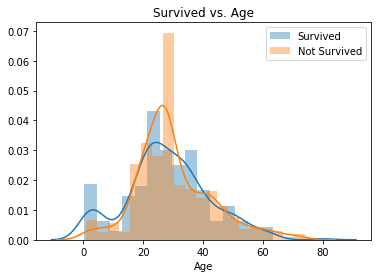

In [13]:
# Bivariate plot of Survived vs. Age
sb.distplot(train[train['Survived']==1]['Age'],label='Survived');
sb.distplot(train[train['Survived']==0]['Age'],label='Not Survived');
plt.legend();
plt.title('Survived vs. Age');

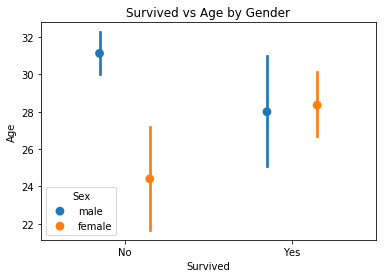

In [14]:
# Multi-variate plot of Survived vs Age by Gender
sb.pointplot(data=train,x='Survived',y='Age',hue='Sex',linestyles="",dodge=0.3);
xticks=[0,1]
xlabel=['No','Yes']
plt.xticks(xticks,xlabel);
plt.title('Survived vs Age by Gender');

From the above plot we can see that mostly middle aged women and men survived. The large error bars mean that the number of data for that point is less. Hence more females survived than men. 

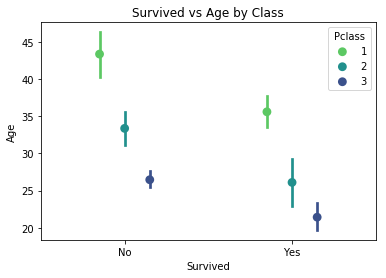

In [15]:
# Multi-variate plot of Survived vs Age by Class
sb.pointplot(data=train,x='Survived',y='Age',hue='Pclass',linestyles="",dodge=0.3,palette='viridis_r');
xticks=[0,1]
xlabel=['No','Yes']
plt.xticks(xticks,xlabel);
plt.title('Survived vs Age by Class');

## Model and Predict

In [16]:
'''
single=[train,test]
# Map columns to numerical values
for data in single:
    data['Sex']=data['Sex'].map({'female':1,'male':0}).astype(int)
    data['Embarked']=data['Embarked'].map({'S':1,'C':2,'Q':3}).astype(int)
'''

"\nsingle=[train,test]\n# Map columns to numerical values\nfor data in single:\n    data['Sex']=data['Sex'].map({'female':1,'male':0}).astype(int)\n    data['Embarked']=data['Embarked'].map({'S':1,'C':2,'Q':3}).astype(int)\n"

In [17]:
# Merge the two datasets
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test))

In [18]:
# Get dummy variables
all_data=pd.get_dummies(all_data)

In [19]:
# Seperate the combined dataset into test and train data
test=all_data[all_data['Survived'].isnull()]
train=all_data[all_data['PassengerId'].isnull()]

In [20]:
# Check if the new and old sizes are equal
assert train.shape[0]==ntrain
assert test.shape[0]==ntest

In [21]:
# Drop extra columns
test.drop(columns='Survived',inplace=True)
train.drop(columns='PassengerId',inplace=True)
test['PassengerId']=test['PassengerId'].astype(int)

In [22]:
# Divide the data into test and train
X_train=train.drop('Survived',axis=1)
Y_train=train['Survived']
X_test=test.drop('PassengerId',axis=1)

In [23]:
'''
# Fit the model using Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest
'''

'\n# Fit the model using Random Forest\nrandom_forest = RandomForestClassifier(n_estimators=100)\nrandom_forest.fit(X_train, Y_train)\nY_pred = random_forest.predict(X_test)\nrandom_forest.score(X_train, Y_train)\nacc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)\nacc_random_forest\n'

In [24]:
# Fit the model using XGBClassifier
xgb = xgboost.XGBClassifier(learning_rate= 0.01, max_depth= 4, n_estimators= 300, seed= 0)
xgb.fit(X_train,Y_train)
Y_pred = xgb.predict(X_test)

In [25]:
final_df = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })

In [26]:
final_df['Survived']=final_df['Survived'].astype(int)

In [27]:
# Save the dataframe to a csv file
final_df.to_csv('submission.csv',index=False)